In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

OUTPUT_DIR = "../../exports/geolocation"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Saving outputs to:", os.path.abspath(OUTPUT_DIR))


c:\Users\Hunain Mulla\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saving outputs to: c:\Users\Hunain Mulla\Desktop\Bismilla\exports\geolocation


In [2]:
# Download dataset
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

# Load datasets
orders    = pd.read_csv(os.path.join(path, 'olist_orders_dataset.csv'))
reviews   = pd.read_csv(os.path.join(path, 'olist_order_reviews_dataset.csv'))
customers = pd.read_csv(os.path.join(path, 'olist_customers_dataset.csv'))
sellers   = pd.read_csv(os.path.join(path, 'olist_sellers_dataset.csv'))
items     = pd.read_csv(os.path.join(path, 'olist_order_items_dataset.csv'))

print("Data loaded successfully!")
print(f"Orders: {len(orders):,} rows")
print(f"Reviews: {len(reviews):,} rows")
print(f"Customers: {len(customers):,} rows")
print(f"Sellers: {len(sellers):,} rows")
print(f"Items: {len(items):,} rows")


Data loaded successfully!
Orders: 99,441 rows
Reviews: 99,224 rows
Customers: 99,441 rows
Sellers: 3,095 rows
Items: 112,650 rows


In [3]:
# Convert date columns to datetime
for col in ['order_purchase_timestamp', 'order_delivered_customer_date',
            'order_estimated_delivery_date']:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

# Filter for delivered orders and calculate delay metrics
delivered = orders[orders['order_status'] == 'delivered'].copy()
delivered['actual_days']    = (delivered['order_delivered_customer_date'] - delivered['order_purchase_timestamp']).dt.days
delivered['estimated_days'] = (delivered['order_estimated_delivery_date'] - delivered['order_purchase_timestamp']).dt.days
delivered['delay_days']     = delivered['actual_days'] - delivered['estimated_days']
delivered['is_late']        = (delivered['delay_days'] > 0).astype(int)
delivered = delivered.dropna(subset=['delay_days'])

print("Delivery metrics calculated!")
print(f"Delivered orders: {len(delivered):,}")


Delivery metrics calculated!
Delivered orders: 96,470


In [4]:
# Merge customer location data
delivered = delivered.merge(
    customers[['customer_id', 'customer_state']],
    on='customer_id', how='left'
)

# Merge seller location data
order_seller = items.groupby('order_id')['seller_id'].first().reset_index()
order_seller = order_seller.merge(
    sellers[['seller_id', 'seller_state']],
    on='seller_id', how='left'
)
delivered = delivered.merge(order_seller[['order_id', 'seller_state']], on='order_id', how='left')

print("Geographic data merged!")
print(f"Orders with location data: {len(delivered):,}")


Geographic data merged!
Orders with location data: 96,470


In [5]:
# State to region mapping
state_to_region = {
    'AC': 'North',        'AM': 'North',        'AP': 'North',    'PA': 'North',
    'RO': 'North',        'RR': 'North',        'TO': 'North',
    'AL': 'Northeast',    'BA': 'Northeast',    'CE': 'Northeast', 'MA': 'Northeast',
    'PB': 'Northeast',    'PE': 'Northeast',    'PI': 'Northeast', 'RN': 'Northeast',
    'SE': 'Northeast',
    'DF': 'Central-West', 'GO': 'Central-West', 'MT': 'Central-West', 'MS': 'Central-West',
    'ES': 'Southeast',    'MG': 'Southeast',    'RJ': 'Southeast', 'SP': 'Southeast',
    'PR': 'South',        'RS': 'South',        'SC': 'South'
}

# Create regional and route columns
delivered['customer_region'] = delivered['customer_state'].map(state_to_region)
delivered['seller_region']   = delivered['seller_state'].map(state_to_region)
delivered['route']           = delivered['seller_state'] + ' → ' + delivered['customer_state']
delivered['region_route']    = delivered['seller_region'] + ' → ' + delivered['customer_region']

print("Regional mappings created!")


Regional mappings created!


In [6]:
print(f"Total delivered orders: {len(delivered):,}")
print(f"Late orders           : {delivered['is_late'].sum():,} ({delivered['is_late'].mean()*100:.1f}%)")
print(f"Average delay         : {delivered['delay_days'].mean():.2f} days")
print(f"Median delay          : {delivered['delay_days'].median():.2f} days")


Total delivered orders: 96,470
Late orders           : 7,307 (7.6%)
Average delay         : -11.28 days
Median delay          : -12.00 days


In [7]:
# Customer state delay analysis
cust_state = delivered.groupby('customer_state').agg(
    order_count  = ('delay_days', 'count'),
    avg_delay    = ('delay_days', 'mean'),
    late_rate    = ('is_late',    'mean'),
    median_delay = ('delay_days', 'median')
).reset_index().sort_values('avg_delay', ascending=False)

cust_state['late_rate_pct'] = cust_state['late_rate'] * 100

print("=== TOP 10 CUSTOMER STATES BY AVG DELAY ===")
display(cust_state[['customer_state', 'order_count', 'avg_delay', 'late_rate_pct']].head(10))


=== TOP 10 CUSTOMER STATES BY AVG DELAY ===


,customer_state,order_count,avg_delay,late_rate_pct
1,AL,397,-8.168766,22.921914
9,MA,717,-8.966527,18.828452
24,SE,335,-9.453731,15.223881
7,ES,1995,-9.888221,11.829574
5,CE,1279,-10.186865,14.855356
4,BA,3256,-10.206695,13.206388
11,MS,701,-10.406562,10.984308
25,SP,40494,-10.478021,5.329185
16,PI,476,-10.707983,15.126050
23,SC,3546,-10.931190,9.165257


In [8]:
# Seller state delay analysis
sell_state = delivered.groupby('seller_state').agg(
    order_count  = ('delay_days', 'count'),
    avg_delay    = ('delay_days', 'mean'),
    late_rate    = ('is_late',    'mean'),
).reset_index().sort_values('avg_delay', ascending=False)

sell_state['late_rate_pct'] = sell_state['late_rate'] * 100

print("=== TOP 10 SELLER STATES BY AVG DELAY ===")
display(sell_state[['seller_state', 'order_count', 'avg_delay', 'late_rate_pct']].head(10))


=== TOP 10 SELLER STATES BY AVG DELAY ===


,seller_state,order_count,avg_delay,late_rate_pct
0,AM,3,9.333333,33.333333
10,PA,8,-10.500000,12.500000
21,SP,68415,-10.528612,8.183878
6,MA,388,-10.703608,20.876289
15,RJ,4185,-11.801434,8.052569
1,BA,549,-11.972678,5.646630
4,ES,308,-12.493506,6.493506
3,DF,803,-12.653798,5.853051
2,CE,85,-12.658824,9.411765
7,MG,7647,-12.727475,5.270041


In [9]:
# Regional analysis
cust_region = delivered.groupby('customer_region').agg(
    order_count = ('delay_days', 'count'),
    avg_delay   = ('delay_days', 'mean'),
    late_rate   = ('is_late',    'mean'),
).reset_index().sort_values('avg_delay', ascending=False)
cust_region['late_rate_pct'] = cust_region['late_rate'] * 100

print("=== CUSTOMER REGION ANALYSIS ===")
display(cust_region)


=== CUSTOMER REGION ANALYSIS ===


,customer_region,order_count,avg_delay,late_rate,late_rate_pct
2,Northeast,9044,-10.749226,0.136665,13.666519
4,Southeast,66193,-10.957382,0.069207,6.920671
0,Central-West,5624,-11.723506,0.073969,7.396871
3,South,13813,-12.502570,0.065373,6.537320
1,North,1796,-15.005568,0.095212,9.521158


In [10]:
# Create heatmap data
region_pivot = delivered.groupby(['seller_region', 'customer_region'])['delay_days'].mean().unstack()

# Top routes analysis
routes = delivered.groupby('region_route').agg(
    order_count = ('delay_days', 'count'),
    avg_delay   = ('delay_days', 'mean'),
    late_rate   = ('is_late',    'mean'),
).reset_index()
routes['late_rate_pct'] = routes['late_rate'] * 100
routes = routes[routes['order_count'] >= 50].sort_values('avg_delay', ascending=False)

print("=== TOP ROUTES BY AVG DELAY (min 50 orders) ===")
display(routes.head(10)[['region_route', 'order_count', 'avg_delay', 'late_rate_pct']])


=== TOP ROUTES BY AVG DELAY (min 50 orders) ===


,region_route,order_count,avg_delay,late_rate_pct
22,Southeast → Southeast,56305,-10.343415,7.200071
2,Central-West → Northeast,171,-10.350877,12.865497
20,Southeast → Northeast,7595,-10.728637,13.785385
0,Central-West → Central-West,206,-10.762136,3.883495
15,South → Northeast,840,-10.876190,14.404762
10,Northeast → Northeast,434,-11.129032,10.368664
18,Southeast → Central-West,4657,-11.380502,7.945029
16,South → South,3055,-12.208183,4.418985
8,Northeast → Central-West,120,-12.416667,10.833333
21,Southeast → South,10492,-12.580442,7.043462


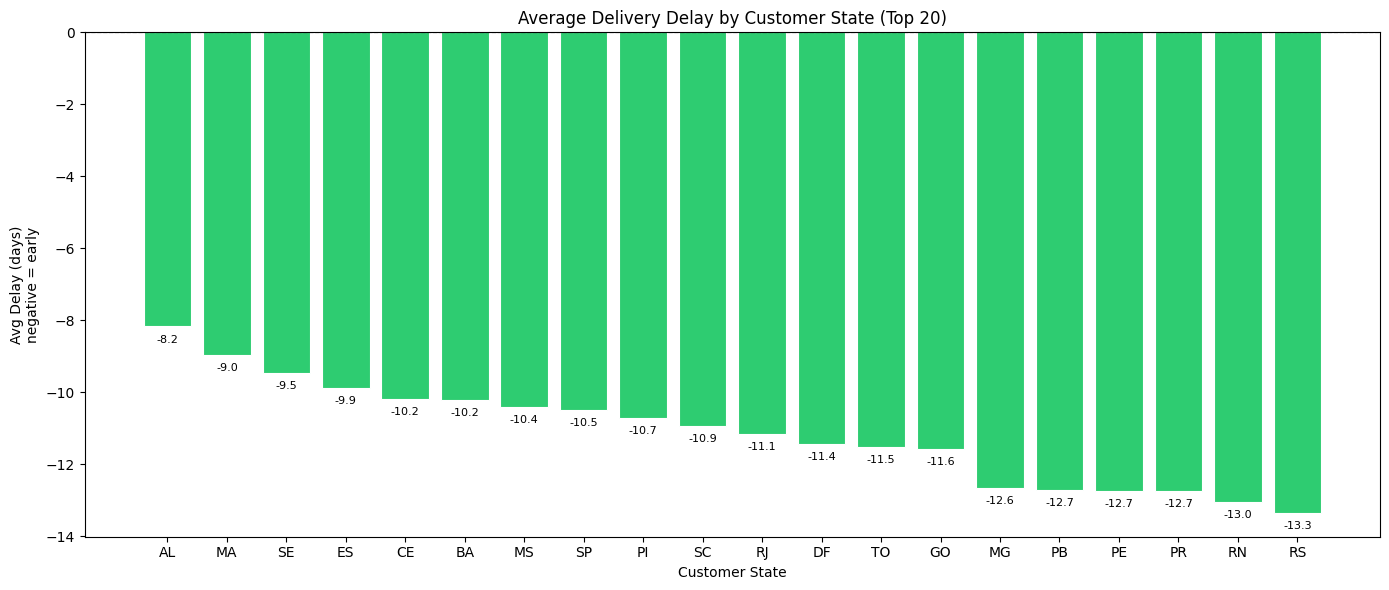

In [ ]:
plt.figure(figsize=(14, 6))

top20_cust = cust_state.head(20)
bar_colors = ['#e74c3c' if d > 0 else '#2ecc71' for d in top20_cust['avg_delay']]

bars = plt.bar(top20_cust['customer_state'],
               top20_cust['avg_delay'],
               color=bar_colors,
               edgecolor='white',
               linewidth=0.8)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Average Delivery Delay by Customer State (Top 20)')
plt.xlabel('Customer State')
plt.ylabel('Avg Delay (days)\nnegative = early')

for bar, val in zip(bars, top20_cust['avg_delay']):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (0.2 if val >= 0 else -0.5),
             f'{val:.1f}',
             ha='center',
             va='bottom',
             fontsize=8)

image_path = os.path.join(OUTPUT_DIR, "visualizations")
plt.tight_layout()
plt.savefig(os.path.join(image_path, "customer_state_delay.png"),
            dpi=150,
            bbox_inches="tight")
plt.show()

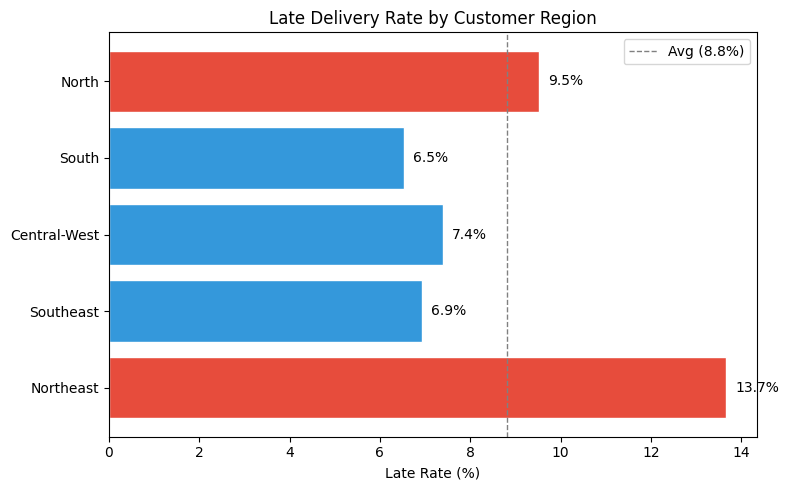

In [12]:
plt.figure(figsize=(8, 5))

region_colors = [
    '#e74c3c' if r > cust_region['late_rate_pct'].mean()
    else '#3498db'
    for r in cust_region['late_rate_pct']
]

bars2 = plt.barh(cust_region['customer_region'],
                 cust_region['late_rate_pct'],
                 color=region_colors,
                 edgecolor='white')

plt.axvline(cust_region['late_rate_pct'].mean(),
            color='gray',
            linestyle='--',
            linewidth=1,
            label=f'Avg ({cust_region["late_rate_pct"].mean():.1f}%)')

for bar, val in zip(bars2, cust_region['late_rate_pct']):
    plt.text(val + 0.2,
             bar.get_y() + bar.get_height()/2,
             f'{val:.1f}%',
             va='center')

plt.title('Late Delivery Rate by Customer Region')
plt.xlabel('Late Rate (%)')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "customer_region_delay.png"),
            dpi=150,
            bbox_inches="tight")
plt.show()

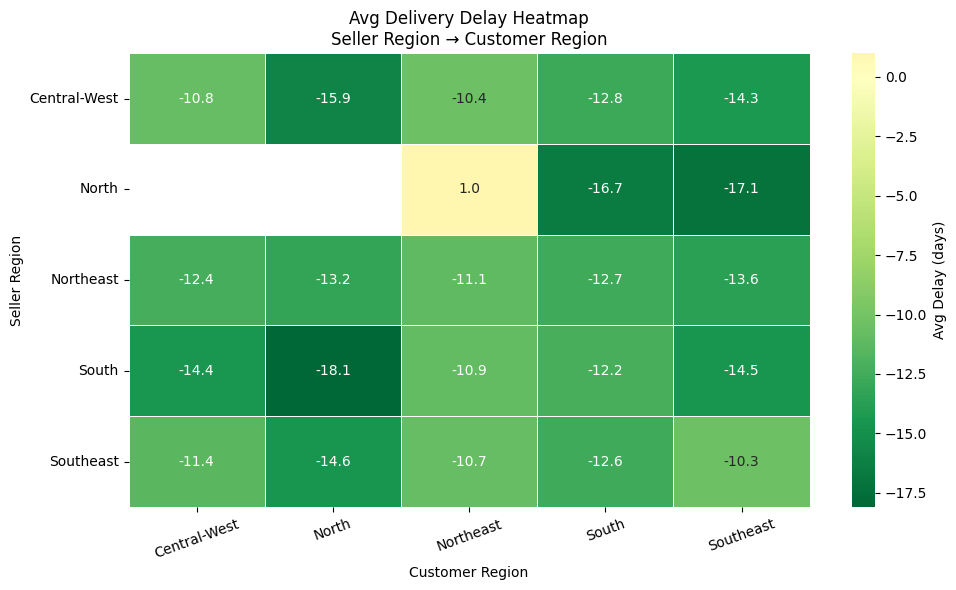

In [13]:
plt.figure(figsize=(10, 6))

if not region_pivot.empty:
    sns.heatmap(
        region_pivot,
        annot=True,
        fmt='.1f',
        cmap='RdYlGn_r',
        center=0,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': 'Avg Delay (days)'}
    )

    plt.title('Avg Delivery Delay Heatmap\nSeller Region → Customer Region')
    plt.xlabel('Customer Region')
    plt.ylabel('Seller Region')
    plt.xticks(rotation=20)
    plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "avg_delivery_heatmap.png"),
            dpi=150,
            bbox_inches="tight")
plt.show()